# 使用卷积神经网络识别MNIST手写体数字

## 一、项目说明

本次案例，通过两种方式实现MNIST手写数字识别。

## 二、数据准备

2.1 引入需要使用的库

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
mpl.rcParams['font.size']=20
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [3,7]
mpl.rcParams['font.family']=['simhei']
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,layers
print(tf.__version__)
print(tf.test.is_gpu_available())
# import warnings
# warnings.filterwarnings("ignore")

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


2.2 MNIST数据集介绍

MNSIT手写数字识别，是一个类似于深度学习的“Hello World”入门项目。

随机查看一下数据集中的图片：

In [2]:
(x,y),(x_test,y_test) = datasets.mnist.load_data()
print('x:',x.shape,'y:',y.shape,'x_test:',x_test.shape,'y_test:',y_test.shape)

x: (60000, 28, 28) y: (60000,) x_test: (10000, 28, 28) y_test: (10000,)


图片对应的数字 4


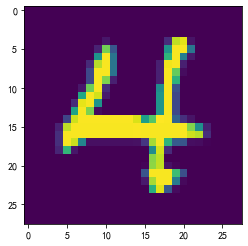

In [3]:
index = random.randint(0, len(x))
plt.figure()
plt.imshow(x[index])
print('图片对应的数字',y[index])

2.3 数据处理

In [4]:
# 预处理
def preprocess(x,y):
    print(x.shape, y.shape)
    x = tf.cast(x, dtype=tf.float32) / 255.
    x = tf.reshape(x, [-1, 28*28])
    y=tf.cast(y, dtype=tf.int32)
    y = tf.one_hot(y, depth=10)
    
    return x,y 

In [5]:
# 通过 Dataset.from_tensor_slices 将训练部分的数据图片转换成Dataset对象
# 随机打散
batchsz = 512
train_db = tf.data.Dataset.from_tensor_slices((x,y))
train_db = train_db.shuffle(1000).batch(batchsz).map(preprocess).repeat(20)

(None, 28, 28) (None,)


In [6]:
x, y = next(iter(train_db))
print('train sample:', x.shape, y.shape)

train sample: (512, 784) (512, 10)


In [7]:
test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_db = test_db.shuffle(1000).batch(batchsz).map(preprocess)

(None, 28, 28) (None,)


## 三、模型搭建

0 loss: 0.7479828000068665
0 Evaluate Acc: 0.0717
80 loss: 0.1941160261631012
80 Evaluate Acc: 0.1966
160 loss: 0.14924101531505585
160 Evaluate Acc: 0.2923
240 loss: 0.12567868828773499
240 Evaluate Acc: 0.3703
320 loss: 0.11462888866662979
320 Evaluate Acc: 0.4282
400 loss: 0.10512051731348038
400 Evaluate Acc: 0.4751
480 loss: 0.09820780903100967
480 Evaluate Acc: 0.5117
560 loss: 0.09505506604909897
560 Evaluate Acc: 0.5386
640 loss: 0.0884239450097084
640 Evaluate Acc: 0.5614
720 loss: 0.08164054900407791
720 Evaluate Acc: 0.5815
800 loss: 0.08105506747961044
800 Evaluate Acc: 0.6002
880 loss: 0.07548630982637405
880 Evaluate Acc: 0.6179
960 loss: 0.0788445919752121
960 Evaluate Acc: 0.631
1040 loss: 0.07629778236150742
1040 Evaluate Acc: 0.6439
1120 loss: 0.0713794082403183
1120 Evaluate Acc: 0.6547
1200 loss: 0.0668473169207573
1200 Evaluate Acc: 0.6653
1280 loss: 0.0697622150182724
1280 Evaluate Acc: 0.6757
1360 loss: 0.07314433157444
1360 Evaluate Acc: 0.6859
1440 loss: 0.0661

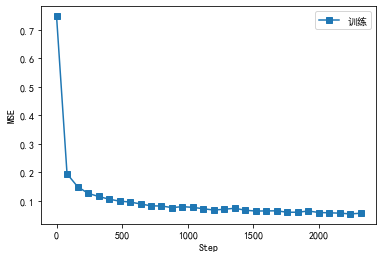

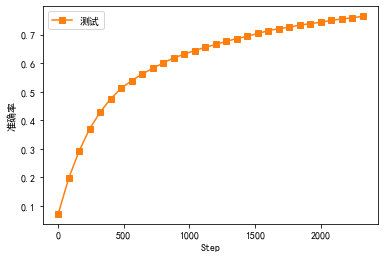

In [8]:
def main(lr=1e-2):
    #learning rate
    # lr = 1e-2
    accs, losses = [], []
    
    # 784 -> 256
    w1, b1 = tf.Variable(tf.random.normal([784,256],stddev=0.1)), tf.Variable(tf.zeros([256]))
    # 256 -> 128
    w2, b2 = tf.Variable(tf.random.normal([256,128],stddev=0.1)), tf.Variable(tf.zeros([128]))
    # 128 -> 10
    w3, b3 = tf.Variable(tf.random.normal([128,10],stddev=0.1)), tf.Variable(tf.zeros([10]))
    
    for step, (x,y) in enumerate(train_db):
        # [b, 28,28] =>[b, 784]
        x=tf.reshape(x, (-1, 784))
        with tf.GradientTape() as tape:
            # layer1
            h1 = x @ w1 + b1
            h1 = tf.nn.relu(h1)
            # layer2
            h2 = h1 @ w2 + b2
            h2 = tf.nn.relu(h2)
            
            # output
            out = h2 @ w3 + b3
            
            # compute loss
            # [b, 10] - [b, 10]
            loss = tf.square(y-out) # 均方差
            # [b, 10] => scalar
            loss = tf.reduce_mean(loss)
            
        grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])
        for p,g in zip([w1, b1, w2, b2, w3, b3], grads):
            p.assign_sub(lr * g)
            
        # print
        if step % 80 == 0:
            print(step, 'loss:', float(loss))
            losses.append(float(loss))
        
        if step % 80 ==0:
            # evaluate/test
            total, total_correct = 0., 0
            for x, y in test_db:
                # layer1
                h1 = x @ w1 + b1
                h1 = tf.nn.relu(h1)
                # layer2
                h2 = h1 @ w2 + b2
                h2 = tf.nn.relu(h2)
                # output
                out = h2 @ w3 + b3
                # [b, 10] -> [b]
                pred = tf.argmax(out, axis=1)
                # convert ont_hot y to nuber y
                y = tf.argmax(y, axis=1)
                # bool type
                correct = tf.equal(pred, y)
                # bool tensor -> int tensor -> numpy
                total_correct += tf.reduce_sum(tf.cast(correct, dtype=tf.int32)).numpy()
                total += x.shape[0]
            
            print(step, 'Evaluate Acc:', total_correct/total)
            
            accs.append(total_correct/total)
            
    plt.figure()
    x = [i*80 for i in range(len(losses))]
    plt.plot(x, losses, color='C0', marker='s', label='训练')
    plt.ylabel('MSE')
    plt.xlabel('Step')
    plt.legend()
    plt.savefig('train.svg')

    plt.figure()
    plt.plot(x, accs, color='C1', marker='s', label='测试')
    plt.ylabel('准确率')
    plt.xlabel('Step')
    plt.legend()
    plt.savefig('test.svg')

main()

In [ ]:
# main(lr=0.02)

In [ ]:
# main(0.03)

## 四、使用keras的API搭建网络(全连接层)

In [9]:
(x,y),(x_test,y_test) = datasets.mnist.load_data()
# 搭建模型
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
'''
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',# 目标函数调整方法
#                 std
             metrics = ['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.layers

In [12]:
history = model.fit(x, y, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 45us/sample - loss: 1.3033 - accuracy: 0.8321
Epoch 2/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.3066 - accuracy: 0.9240
Epoch 3/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.2042 - accuracy: 0.9457
Epoch 4/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.1636 - accuracy: 0.9567
Epoch 5/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1416 - accuracy: 0.9628
Epoch 6/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1224 - accuracy: 0.9682
Epoch 7/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1157 - accuracy: 0.9720
Epoch 8/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1042 - accuracy: 0.9746
Epoch 9/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0994 - accuracy: 0.9762
Epoch 10/10
60

In [13]:
evaluation = model.evaluate(x_test,y_test)
print(evaluation)

10000/10000 [==============================] - 0s 31us/sample - loss: 0.1273 - accuracy: 0.9738
[0.12734866554984473, 0.9738]


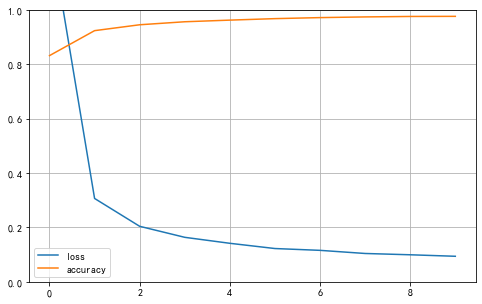

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True) # 网格
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [15]:
x=x/255.

In [16]:
# 搭建模型
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',# 目标函数调整方法
             metrics = ['accuracy'])

In [17]:
history = model.fit(x, y, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.2488 - accuracy: 0.9252
Epoch 2/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1230 - accuracy: 0.9616
Epoch 3/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0932 - accuracy: 0.9711
Epoch 4/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0700 - accuracy: 0.9778
Epoch 5/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0578 - accuracy: 0.9810
Epoch 6/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0507 - accuracy: 0.9826
Epoch 7/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0415 - accuracy: 0.9866
Epoch 8/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0404 - accuracy: 0.9867
Epoch 9/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0310 - accuracy: 0.9899
Epoch 10/10
60

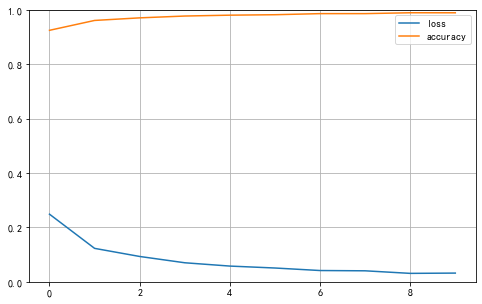

In [18]:
plot_learning_curves(history)

In [19]:
x_test=x_test/255.
evaluation = model.evaluate(x_test,y_test)
print(evaluation)

10000/10000 [==============================] - 0s 29us/sample - loss: 0.0995 - accuracy: 0.9766
[0.09952929154243188, 0.9766]


## 五、使用keras的API搭建网络(卷积神经)

In [20]:
# 导入数据
(x,y),(x_test,y_test) = datasets.mnist.load_data()

In [21]:
# 对X进行类型转换和归一化
x_train = x.reshape(x.shape[0],28,28,1).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,1).astype('float32')

In [22]:
x_train /= 255.
x_test /= 255.

In [23]:
y[0]

5

In [24]:
x_train[0].shape

(28, 28, 1)

In [25]:
# 定义网络结构，搭建模型
model = keras.models.Sequential([ # 网络容器
    layers.Conv2D(36,kernel_size=3,strides=1), # 第一个卷积层, 6个3x3卷积核
    layers.MaxPooling2D(pool_size=2,strides=2), # 高宽各减半的池化层
    layers.ReLU(), # 激活函数
    layers.Conv2D(66,kernel_size=3,strides=1), # 第二个卷积层, 16个3x3卷积核
    layers.MaxPooling2D(pool_size=2,strides=2), # 高宽各减半的池化层
    layers.ReLU(), # 激活函数
    layers.Flatten(), # 打平层，方便全连接层处理

    layers.Dense(120, activation='relu'), # 全连接层，120个节点
    layers.Dense(84, activation='relu'), # 全连接层，84节点
    layers.Dense(10,activation='softmax') # 全连接层，10个节点
                    ])
# build一次网络模型，给输入X的形状，其中4为随意给的batchsz
model.build(input_shape=(4, 28, 28, 1)) # 32 64 128
# 统计网络信息
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  360       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  21450     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu_1 (ReLU)               multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                 

In [26]:
model.layers

In [27]:
model.compile(
    loss='sparse_categorical_crossentropy',
#     optimizer='Adadelta',
    optimizer='adam',
    metrics=['accuracy']
    )

In [28]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES'] = "0,1" #选择哪一块gpu,如果是-1，就是调用cpu

In [29]:
model.fit(x_train, y, batch_size=50, epochs=10)


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 16s 260us/sample - loss: 0.1546 - accuracy: 0.9526
Epoch 2/10
60000/60000 [==============================] - 16s 274us/sample - loss: 0.0477 - accuracy: 0.9850
Epoch 3/10
60000/60000 [==============================] - 16s 272us/sample - loss: 0.0319 - accuracy: 0.9896
Epoch 4/10
60000/60000 [==============================] - 16s 269us/sample - loss: 0.0244 - accuracy: 0.9922
Epoch 5/10
60000/60000 [==============================] - 16s 273us/sample - loss: 0.0186 - accuracy: 0.9937
Epoch 6/10
60000/60000 [==============================] - 17s 285us/sample - loss: 0.0153 - accuracy: 0.9954
Epoch 7/10
60000/60000 [==============================] - 16s 272us/sample - loss: 0.0119 - accuracy: 0.9961
Epoch 8/10
60000/60000 [==============================] - 17s 279us/sample - loss: 0.0089 - accuracy: 0.9969
Epoch 9/10
60000/60000 [==============================] - 16s 271us/sample - loss: 0.0087 - accuracy: 0.9

In [30]:
evaluation = model.evaluate(x_test,y_test)
print(evaluation)

10000/10000 [==============================] - 1s 103us/sample - loss: 0.0382 - accuracy: 0.9910
[0.03823280554570401, 0.991]
